# **ĐỒ ÁN CUỐI KỲ: PHÂN TÍCH CẢM XÚC ĐÁNH GIÁ (SENTIMENT ANALYSIS)**
## **Môn học:** Nhập môn Trí tuệ Nhân tạo
---

### **👥 THÔNG TIN NHÓM THỰC HIỆN**

| **STT** | **Họ và Tên** | **MSV** | **Vai trò** | **Đóng góp** |
|:---:|:---|:---|:---|:---|
| 1 | **Đồng Quốc Đại** | 23001513 | **Trưởng nhóm** | Xây dựng mô hình **PhoBERT Large**, Tối ưu hóa huấn luyện (Gradient Accumulation), Cấu hình Colab GPU |
| 2 | **Chu Thành Dũng** | 23001506 | Thành viên | Thu thập dữ liệu, Xử lý NLP Tiếng Việt (Tách từ), Viết báo cáo |
| 3 | **Nguyễn Mạnh Dũng** | 23001507 | Thành viên | Trực quan hóa dữ liệu, Làm Slide, Kiểm thử & Demo mô hình |

---

### **📝 MÔ TẢ DỰ ÁN**
* **Mục tiêu:** Xây dựng mô hình AI tiên tiến tự động phân loại bình luận khách hàng thành 3 nhóm: *Tích cực, Trung lập, Tiêu cực*.
* **Dữ liệu:** `comments.csv` (Dữ liệu thực tế từ sàn TMĐT Tiki).
* **Công nghệ & Kỹ thuật:**
    * **Mô hình:** **PhoBERT Large** (State-of-the-art cho tiếng Việt).
    * **Framework:** **PyTorch**, **Hugging Face Transformers**.
    * **Xử lý ngôn ngữ:** **Underthesea** (Tách từ chuyên sâu).
    * **Kỹ thuật tối ưu:** Gradient Accumulation & Mixed Precision (FP16) để chạy mô hình lớn trên tài nguyên hạn chế.
    * **Phần cứng:** Google Colab T4 GPU.

### **📂 CẤU TRÚC NOTEBOOK**
1.  **Cài đặt & Import:** Thiết lập môi trường PyTorch và thư viện NLP.
2.  **Tiền xử lý Dữ liệu:** Làm sạch, chuẩn hóa và **Tách từ (Word Segmentation)**.
3.  **Tokenizer:** Mã hóa văn bản theo chuẩn của PhoBERT Large.
4.  **Cấu hình Trainer:** Thiết lập tham số huấn luyện tiết kiệm bộ nhớ (Batch size nhỏ + Tích lũy Gradient).
5.  **Huấn luyện (Fine-tuning):** Dạy mô hình trên tập dữ liệu Tiki.
6.  **Đánh giá & Demo:** Kiểm tra độ chính xác, vẽ biểu đồ ROC-AUC và tạo App dự đoán.

---

In [ ]:
# KHỐI 1: CÀI ĐẶT MÔI TRƯỜNG
# ------------------------------------------------------------------
# Chạy xong khối này, nếu Colab yêu cầu Restart Session thì bấm nút Restart
# ------------------------------------------------------------------

!pip install transformers datasets accelerate underthesea scikit-learn
!pip install torch torchvision torchaudio

print("✅ ĐÃ CÀI ĐẶT XONG.")

✅ ĐÃ CÀI ĐẶT XONG.


## **1. Cài đặt Môi trường và Thư viện**
Cài đặt các thư viện cần thiết bao gồm `transformers` (cho PhoBERT), `underthesea` (cho tách từ tiếng Việt), và các công cụ xử lý dữ liệu khác.
> *Lưu ý: Sau khi chạy xong khối này, cần khởi động lại Runtime (Restart Session).*

In [ ]:
# KHỐI 2: IMPORT THƯ VIỆN
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from underthesea import word_tokenize

# Hugging Face Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Đang chạy trên thiết bị: {device}")

if str(device) == 'cpu':
    print("⚠️ CẢNH BÁO: Bạn chưa bật GPU T4! Hãy vào Runtime -> Change runtime type ngay.")

🔥 Đang chạy trên thiết bị: cuda


## **3. Tải Dữ liệu và Tiền xử lý NLP**
- Đọc file dữ liệu `comments.csv`.
- Gán nhãn cảm xúc dựa trên số sao (4-5 sao: Tích cực, 3 sao: Trung lập, 1-2 sao: Tiêu cực).
- **Tách từ (Word Segmentation):** Sử dụng `underthesea` để ghép các từ đơn thành từ ghép có nghĩa (VD: "giao" + "hàng" -> "giao_hàng").
- Chia tập dữ liệu thành Train (Huấn luyện) và Test (Kiểm thử).

In [ ]:
# KHỐI 3: TẢI DATA & TÁCH TỪ TIẾNG VIỆT
file_path = '/content/comments.csv'

# 1. Đọc file
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except FileNotFoundError:
    print("❌ LỖI: Không tìm thấy file 'comments.csv'. Hãy upload file lên Colab!")
    raise
except:
    df = pd.read_csv(file_path, encoding='utf-8-sig')

# 2. Lọc dữ liệu
df = df[['rating', 'content']].dropna()
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df.dropna(subset=['rating'], inplace=True)

# 3. Gán nhãn (Label Mapping) - Bắt buộc từ 0, 1, 2
def map_label(rating):
    if rating in [4, 5]: return 2 # Positive
    if rating == 3: return 1      # Neutral
    if rating in [1, 2]: return 0 # Negative

df['label'] = df['rating'].apply(map_label)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# 4. Tách từ (Word Segmentation) - QUAN TRỌNG CHO PHOBERT
print("⏳ Đang tách từ (Word Segmentation)...")
# Hàm này nối từ ghép bằng dấu gạch dưới _ (VD: giao_hàng)
df['content_seg'] = df['content'].apply(lambda x: word_tokenize(str(x), format="text"))

# 5. Chia tập Train/Test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# 6. Chuyển sang định dạng Dataset của HuggingFace
train_dataset = Dataset.from_pandas(train_df[['content_seg', 'label']])
test_dataset = Dataset.from_pandas(test_df[['content_seg', 'label']])

print("✅ Đã xử lý xong dữ liệu!")
print(f"Mẫu tách từ: {train_df['content_seg'].iloc[0]}")

⏳ Đang tách từ (Word Segmentation)...
✅ Đã xử lý xong dữ liệu!
Mẫu tách từ: Lúc đầu mua mình đắn_đo lắm vì giá sách cao hơn so với những cuốn mình thường mua . Nhưng vì đầu_tư kiến_thức nên mình quyết_định order . Sách_đc bao_bọc rất kĩ , xứng_đáng với giá tiền thật_sự !


## **4. Tokenizer (Mã hóa văn bản)**
Sử dụng Tokenizer của `vinai/phobert-large` để chuyển đổi văn bản tiếng Việt thành các chuỗi số mà mô hình có thể hiểu được. Áp dụng padding và truncation để đồng nhất độ dài câu.

In [ ]:
# KHỐI 4: TOKENIZER (PHIÊN BẢN LARGE)

MODEL_NAME = "vinai/phobert-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["content_seg"],
        padding="max_length",
        truncation=True,
        max_length=128  # Giữ 128 là an toàn nhất để không tràn RAM
    )

print(f"⏳ Đang mã hóa dữ liệu với {MODEL_NAME}...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
print("✅ Mã hóa xong!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

⏳ Đang mã hóa dữ liệu với vinai/phobert-large...


Map:   0%|          | 0/82610 [00:00<?, ? examples/s]

Map:   0%|          | 0/20653 [00:00<?, ? examples/s]

✅ Mã hóa xong!


## **5. Cấu hình Huấn luyện (Training Arguments)**
Thiết lập các tham số siêu hình cho quá trình huấn luyện.
> **Kỹ thuật tối ưu:** Sử dụng *Gradient Accumulation* và giảm *Batch size* xuống mức thấp để có thể chạy mô hình Large trên bộ nhớ hạn chế của Colab/Kaggle mà không bị tràn RAM (OOM).

In [ ]:
# KHỐI 5: CẤU HÌNH TRAINER CHO PHOBERT LARGE
# ---------------------------------------------------------
# Cấu hình "ép cân" để chạy được model to trên máy miễn phí
# ---------------------------------------------------------

# Tải Model Large
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": acc, "f1_macro": f1}

# THAM SỐ QUAN TRỌNG
training_args = TrainingArguments(
    output_dir="./results_phobert_large",
    num_train_epochs=4,              # Model lớn cần học kỹ hơn (4 epochs)

    # --- BÍ KÍP CHỐNG TRÀN RAM ---
    per_device_train_batch_size=4,   # Giảm xuống 4 (hoặc 2 nếu vẫn lỗi)
    gradient_accumulation_steps=4,   # Tích lũy 4 lần (Tương đương batch size thực tế = 16)
    per_device_eval_batch_size=8,    # Lúc test thì nhẹ hơn, để 8 được
    fp16=True,                       # BẬT chế độ 16-bit (Giảm 50% RAM, chạy nhanh hơn)
    # -----------------------------

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,              # Chỉ giữ 1 file model tốt nhất
    learning_rate=1e-5,              # Model lớn cần học chậm hơn (1e-5)
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)

# Khởi tạo Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

print(f"✅ Đã thiết lập Trainer cho {MODEL_NAME}!")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Đã thiết lập Trainer cho vinai/phobert-large!


## **6. Huấn luyện Mô hình (Training)**
Bắt đầu quá trình Fine-tuning mô hình PhoBERT trên tập dữ liệu đã chuẩn bị. Quá trình này sẽ mất một khoảng thời gian tùy thuộc vào GPU.

In [ ]:
print("🚀 BẮT ĐẦU HUẤN LUYỆN PHOBERT LARGE...")
trainer.train()

🚀 BẮT ĐẦU HUẤN LUYỆN PHOBERT LARGE...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.208200,0.214498,0.928146,0.678137
2,0.175400,0.188799,0.933666,0.733475
3,0.135600,0.218121,0.938411,0.747467
4,0.112300,0.249366,0.938024,0.753534


TrainOutput(global_step=20656, training_loss=0.16838275453639898, metrics={'train_runtime': 11407.5601, 'train_samples_per_second': 28.967, 'train_steps_per_second': 1.811, 'total_flos': 7.698711004689408e+16, 'train_loss': 0.16838275453639898, 'epoch': 4.0})

## **7. Trực quan hóa Kết quả Huấn luyện (Visualization)**

Để đánh giá độ ổn định và hiệu suất của mô hình, chúng ta sử dụng hai loại biểu đồ quan trọng:

1.  **Biểu đồ Lịch sử Huấn luyện (Training History):**
    * Theo dõi sự thay đổi của độ chính xác (**Accuracy**) và độ mất mát (**Loss**) qua từng Epoch.
    * Giúp phát hiện hiện tượng **Overfitting** (nếu đường Validation tách xa đường Train) hoặc **Underfitting**.
2.  **Ma trận Nhầm lẫn (Confusion Matrix):**
    * Cho cái nhìn chi tiết về việc mô hình đang dự đoán đúng/sai ở lớp nào.
    * Đặc biệt quan trọng để kiểm tra xem mô hình có phân biệt tốt giữa các lớp *Tiêu cực* và *Tích cực* hay không.

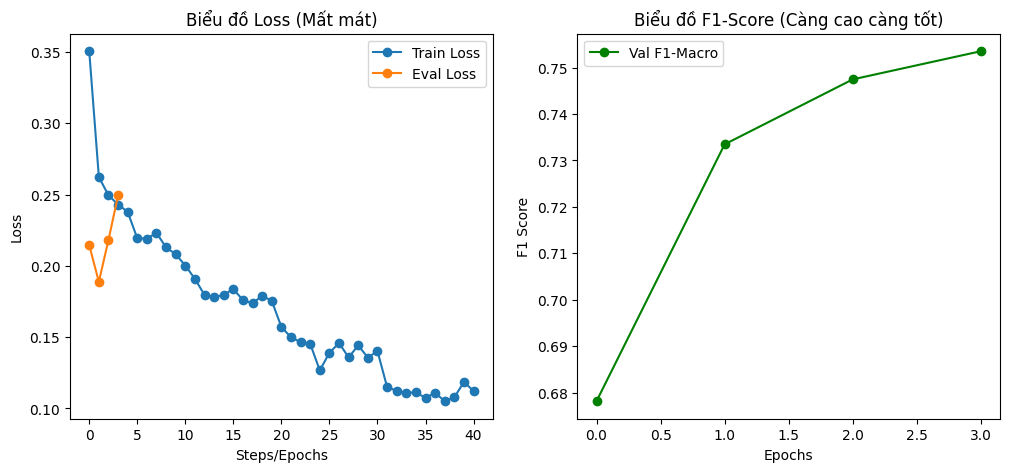


--- KẾT QUẢ ĐÁNH GIÁ ---


              precision    recall  f1-score   support

    Negative       0.80      0.74      0.77      1437
     Neutral       0.49      0.54      0.51      1046
    Positive       0.98      0.98      0.98     18170

    accuracy                           0.94     20653
   macro avg       0.76      0.75      0.75     20653
weighted avg       0.94      0.94      0.94     20653



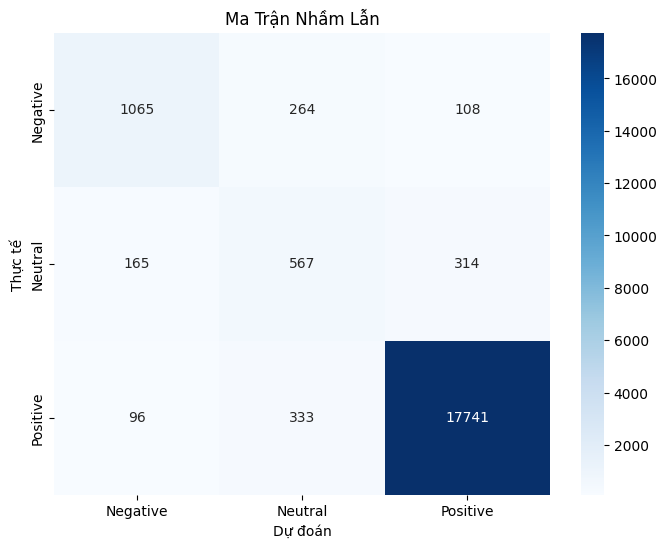

In [ ]:
# KHỐI 7: ĐÁNH GIÁ & VẼ BIỂU ĐỒ

# 1. Lấy lịch sử huấn luyện
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_f1 = [x['eval_f1_macro'] for x in history if 'eval_f1_macro' in x]

# Vẽ biểu đồ Loss và F1
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
if len(eval_loss) > 0:
    plt.plot(eval_loss, label='Eval Loss', marker='o')
plt.title('Biểu đồ Loss (Mất mát)')
plt.xlabel('Steps/Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_f1, label='Val F1-Macro', color='green', marker='o')
plt.title('Biểu đồ F1-Score (Càng cao càng tốt)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 2. Đánh giá chi tiết trên tập Test
print("\n--- KẾT QUẢ ĐÁNH GIÁ ---")
preds_output = trainer.predict(tokenized_test)
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = preds_output.label_ids

# In báo cáo
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_true, y_preds, target_names=target_names))

# Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Ma Trận Nhầm Lẫn')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

## **8. Lưu trữ Mô hình**
Lưu lại mô hình đã huấn luyện và Tokenizer để có thể tái sử dụng hoặc triển khai (Deploy) sau này mà không cần train lại.

In [ ]:
# KHỐI 8: LƯU MODEL
save_path = "./my_phobert_sentiment"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Đã lưu model tại: {save_path}")
print("💡 Bạn có thể nén thư mục này lại và tải về máy để dùng sau.")

# Nén zip để tải về (Optional)
!zip -r phobert_model.zip ./my_phobert_sentiment
print("📦 Đã nén thành phobert_model.zip. Hãy tải về từ mục Files bên trái!")

✅ Đã lưu model tại: ./my_phobert_sentiment
💡 Bạn có thể nén thư mục này lại và tải về máy để dùng sau.
updating: my_phobert_sentiment/ (stored 0%)
updating: my_phobert_sentiment/training_args.bin (deflated 53%)
updating: my_phobert_sentiment/tokenizer_config.json (deflated 77%)
updating: my_phobert_sentiment/model.safetensors (deflated 9%)
updating: my_phobert_sentiment/bpe.codes (deflated 59%)
updating: my_phobert_sentiment/config.json (deflated 52%)
updating: my_phobert_sentiment/special_tokens_map.json (deflated 57%)
updating: my_phobert_sentiment/added_tokens.json (stored 0%)
updating: my_phobert_sentiment/vocab.txt (deflated 55%)
📦 Đã nén thành phobert_model.zip. Hãy tải về từ mục Files bên trái!


## **9. Demo Dự đoán Thực tế (Inference Demo)**

Sau khi đã có mô hình hoàn chỉnh, bước này sẽ xây dựng một hàm dự đoán đơn giản để kiểm thử mô hình với các dữ liệu nhập vào bất kỳ từ người dùng.

**Chức năng của khối này:**
* Xây dựng hàm `predict_user_input` để đóng gói toàn bộ quy trình: *Tiền xử lý -> Tokenize -> Dự đoán -> Giải mã nhãn*.
* Thử nghiệm với một danh sách các câu bình luận mẫu (bao gồm cả khen, chê và các câu có cấu trúc phức tạp) để minh họa khả năng hiểu ngữ cảnh của mô hình.

In [ ]:
# KHỐI 9: TEST THỬ NGHIỆM
def predict_phobert(text):
    # a. Tách từ
    text_seg = word_tokenize(text, format="text")
    # b. Mã hóa
    inputs = tokenizer(text_seg, return_tensors="pt", truncation=True, max_length=128, padding=True).to(device)
    # c. Dự đoán
    with torch.no_grad():
        logits = model(**inputs).logits

    # d. Lấy nhãn
    pred_idx = torch.argmax(logits, dim=1).item()
    probs = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()

    labels = {0: 'Negative 😡', 1: 'Neutral 😐', 2: 'Positive 😍'}
    return labels[pred_idx], probs[pred_idx]

# Test các câu "bẫy"
samples = [
    "Sách bìa đẹp nhưng nội dung thì rỗng tuếch.",
    "Không phải là không tốt, tạm chấp nhận được.",
    "Sách đểu, giấy mỏng dính, đừng mua phí tiền.",
    "Giao hàng nhanh, đóng gói kỹ, rất ưng ý.",
    "Shop làm ăn bát nháo, treo đầu dê bán thịt chó"
]

print("-" * 50)
print("KẾT QUẢ DỰ ĐOÁN PHOBERT:")
print("-" * 50)
for s in samples:
    lbl, conf = predict_phobert(s)
    print(f"💬: {s}")
    print(f"👉: {lbl} (Độ tin cậy: {conf*100:.2f}%)")
    print("-" * 30)

--------------------------------------------------
KẾT QUẢ DỰ ĐOÁN PHOBERT:
--------------------------------------------------
💬: Sách bìa đẹp nhưng nội dung thì rỗng tuếch.
👉: Neutral 😐 (Độ tin cậy: 94.02%)
------------------------------
💬: Không phải là không tốt, tạm chấp nhận được.
👉: Positive 😍 (Độ tin cậy: 99.60%)
------------------------------
💬: Sách đểu, giấy mỏng dính, đừng mua phí tiền.
👉: Negative 😡 (Độ tin cậy: 98.36%)
------------------------------
💬: Giao hàng nhanh, đóng gói kỹ, rất ưng ý.
👉: Positive 😍 (Độ tin cậy: 99.96%)
------------------------------
💬: Shop làm ăn bát nháo, treo đầu dê bán thịt chó
👉: Negative 😡 (Độ tin cậy: 98.78%)
------------------------------


## **9. Biểu đồ ROC-AUC**
Vẽ đường cong ROC để đánh giá khả năng phân loại của mô hình ở các ngưỡng khác nhau. Diện tích dưới đường cong (AUC) càng lớn thì mô hình càng tốt.

⏳ Đang tính toán ROC-AUC...


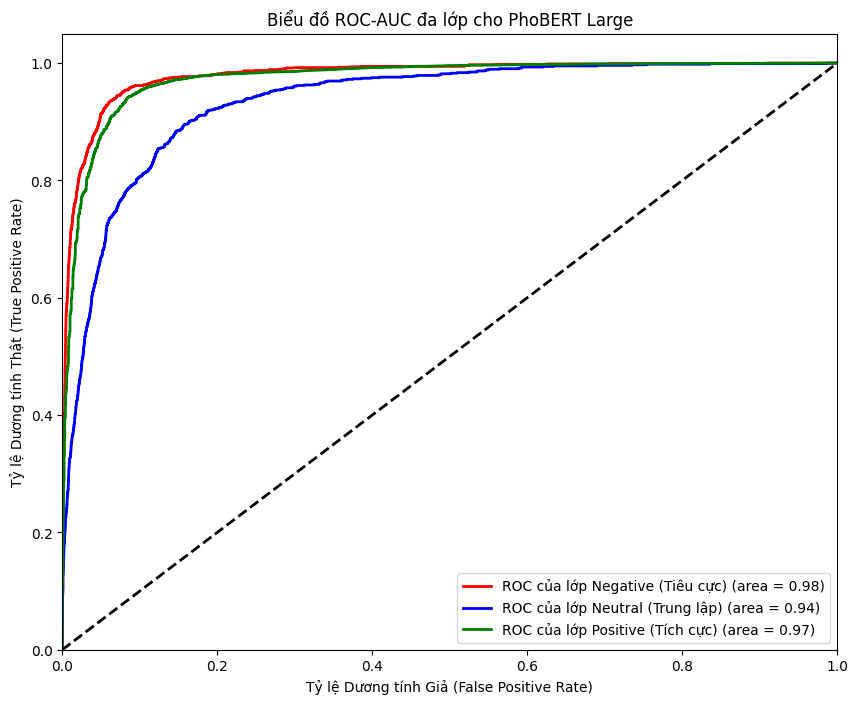

In [ ]:
# KHỐI 10: VẼ ROC-AUC CURVE
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

print("⏳ Đang tính toán ROC-AUC...")

# 1. Chuẩn bị dữ liệu
# Lấy xác suất dự đoán trên tập Test
raw_pred = trainer.predict(tokenized_test)
y_score = raw_pred.predictions  # Logits
# Chuyển logits thành xác suất (Softmax)
y_prob = torch.nn.functional.softmax(torch.tensor(y_score), dim=1).numpy()
y_test_bin = label_binarize(test_dataset['label'], classes=[0, 1, 2])
n_classes = 3

# 2. Tính toán ROC cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Vẽ biểu đồ
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'blue', 'green'])
classes = ['Negative (Tiêu cực)', 'Neutral (Trung lập)', 'Positive (Tích cực)']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC của lớp {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tỷ lệ Dương tính Giả (False Positive Rate)')
plt.ylabel('Tỷ lệ Dương tính Thật (True Positive Rate)')
plt.title('Biểu đồ ROC-AUC đa lớp cho PhoBERT Large')
plt.legend(loc="lower right")
plt.show()

## **10. Demo Ứng dụng Web (Gradio)**
Tạo một giao diện web đơn giản để người dùng có thể nhập bình luận và nhận kết quả phân tích cảm xúc trực tiếp từ mô hình AI.

In [ ]:
# KHỐI 11: TẠO WEB APP DEMO VỚI GRADIO
!pip install gradio

import gradio as gr
import torch

# Hàm dự đoán cho Gradio
def gradio_predict(text):
    # 1. Tách từ
    text_seg = word_tokenize(text, format="text")
    # 2. Mã hóa
    inputs = tokenizer(text_seg, return_tensors="pt", truncation=True, max_length=128, padding=True).to(device)
    # 3. Dự đoán
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)[0]

    # 4. Trả về dạng Dictionary cho Gradio
    return {
        "Negative 😡": float(probs[0]),
        "Neutral 😐": float(probs[1]),
        "Positive 😍": float(probs[2])
    }

# Tạo giao diện
demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=3, placeholder="Nhập bình luận Tiki/Shopee vào đây..."),
    outputs=gr.Label(num_top_classes=3),
    title="🤖 AI PHÂN TÍCH CẢM XÚC (PHOBERT LARGE)",
    description="Nhập một câu bình luận tiếng Việt, AI sẽ đoán xem đó là Khen, Chê hay Bình thường.",
    examples=[
        ["Giao hàng nhanh, đóng gói cẩn thận, sách đẹp."],
        ["Sách bìa thì đẹp nhưng nội dung sáo rỗng, phí tiền."],
        ["Cũng tạm được, không có gì đặc sắc."],
        ["Shop lừa đảo, treo đầu dê bán thịt chó."]
    ]
)

# Chạy ứng dụng
print("🚀 Đang khởi động Web App...")
demo.launch(share=True, debug=True)

🚀 Đang khởi động Web App...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1dc5d44fb72e1e53f6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1dc5d44fb72e1e53f6.gradio.live
